In [87]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from wutorchkeras import wutorchkeras, metrics
import numpy as np
import pandas as pd

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [89]:
trans = transforms.ToTensor()

train_datasets = datasets.FashionMNIST(root='../data', transform=trans, train=True, download=True)
val_datasets = datasets.FashionMNIST(root='../data', transform=trans, train=False, download=True)

In [90]:
train_data = train_datasets.data
train_targets = train_datasets.targets
print(train_data.shape, '-->', train_targets.shape)
train_targets[70]

torch.Size([60000, 28, 28]) --> torch.Size([60000])


tensor(3)

In [91]:
num_epochs, lr, batch_size = 10, 0.5, 256

dl_train = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_datasets, batch_size=batch_size, shuffle=True)



In [92]:
def dropout_layer(X, dropout):
    X = X.to(device)
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float().to(device)
    # print(mask.size(),X.size())
    a = torch.mul(mask, X)
    return mask * X / (1.0 - dropout)


dropout1, dropout2 = 0.2, 0.5
h1_std = []
h2_std = []
dfstd = pd.DataFrame()
class Net(nn.Module):
    def __init__(self, num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=256,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        self.h1 = torch.tensor([])
        self.h2 = torch.tensor([])

    def forward(self, X, is_train=True):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        # if self.training == True:
        #     # 在第一个全连接层之后添加一个dropout层
        #     # H1 = nn.Dropout(dropout1)
        #     H1 = dropout_layer(H1, dropout1)
        # H1 = F.dropout(H1, dropout1, is_train)
        self.h1 = H1
        # print(H1.size())
        # print(torch.var(H1).size())
        # h1_std.append(torch.std(H1))

        H2 = self.relu(self.lin2(H1))
        # H2 = F.dropout(H2, dropout2, is_train)
        self.h2 = H2
        # h2_std.append(torch.std(H2))
        # if self.training == True:
        #     # 在第二个全连接层之后添加一个dropout层
        #     # H2 = nn.Dropout(dropout2)
        #     H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

    def get_h1(self, is_train=False):
        h1 = self.h1.view(-1)
        if is_train:
            # var_tensor = torch.cat((var_tensor, h1))
            return h1
        else:
            return torch.tensor([])

    def get_h2(self, is_train=False):
        h2 = self.h2.view(-1)
        if is_train:
            # var_tensor = torch.cat((var_tensor, h1))
            return h2
        else:
            return torch.tensor([])



In [93]:
model = Net().to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
accuracy = metrics.accuracy


def train_step(features, labels, is_train=True):
    features = features.to(device)
    labels = labels.to(device)
    predictions = model.forward(features, is_train)
    loss = loss_func(predictions, labels)
    acc = accuracy(predictions, labels)
    h1_tensor = model.get_h1(is_train)
    h2_tensor = model.get_h2(is_train)
    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss.item(), acc.item(), h1_tensor, h2_tensor

@torch.no_grad()
def val_step(features, labels, is_train=False):
    model.eval()
    features = features.to(device)
    labels = labels.to(device)
    predictions = model.forward(features, is_train)
    loss = loss_func(predictions, labels)
    acc = accuracy(predictions, labels)

    return loss.item(), acc.item()


def train_model(epochs):
    cols = ['epoch', 'loss', 'acc', 'val_loss', 'val_acc','h1_var','h2_var']
    dfhistory = pd.DataFrame(index=range(1, epochs + 1), columns=cols)
    for epoch in range(1, epochs + 1):
        loss = []
        acc = []
        val_loss = []
        val_acc = []
        H1_tensor = torch.tensor([]).to(device)
        H2_tensor = torch.tensor([]).to(device)

        for features, labels in dl_train:
            loss_i, acc_i, h1_tensor, h2_tensor = train_step(features, labels)
            H1_tensor = torch.cat((H1_tensor, h1_tensor))
            H2_tensor = torch.cat((H2_tensor, h2_tensor))
            loss.append(loss_i)
            acc.append(acc_i)

        for features, labels in dl_val:
            val_loss_i, val_acc_i = val_step(features, labels)
            val_loss.append(val_loss_i)
            val_acc.append(val_acc_i)

        dfhistory.loc[epoch] = {
            'epoch': epoch,
            'loss':np.mean(loss),
            'acc':np.mean(acc),
            'val_loss':np.mean(val_loss),
            'val_acc':np.mean(val_acc),
            'h1_var':torch.var(H1_tensor).item(),
            'h2_var':torch.var(H2_tensor).item()
        }
        print(epoch,loss[-1],acc[-1],val_loss[-1],val_acc[-1],torch.var(H1_tensor).item(),torch.var(H2_tensor).item())

    return dfhistory

dfhistory = train_model(num_epochs)

1 0.4979177713394165 0.8020833333333334 0.43466782569885254 0.875 0.153134286403656 0.13111458718776703
2 0.5829538702964783 0.7291666666666666 0.35132697224617004 0.8125 0.15578901767730713 0.15152864158153534
3 0.37534448504447937 0.84375 1.0873569250106812 0.8125 0.15625296533107758 0.15516942739486694
4 0.5120487809181213 0.7916666666666666 0.22309979796409607 0.9375 0.1586165428161621 0.15645800530910492
5 0.3136686682701111 0.875 0.4019002318382263 0.8125 0.16833630204200745 0.15908648073673248
6 0.5147453546524048 0.8020833333333334 0.7219229340553284 0.625 0.17197950184345245 0.16393524408340454
7 0.39103803038597107 0.8854166666666666 0.18613888323307037 0.9375 0.17375975847244263 0.16482028365135193
8 0.3547189235687256 0.875 0.08692311495542526 1.0 0.1785130351781845 0.16574518382549286
9 0.36419758200645447 0.8645833333333334 0.28778842091560364 0.875 0.17943650484085083 0.1684248000383377
10 0.4044483006000519 0.84375 0.2325843870639801 0.9375 0.18500660359859467 0.1710494

In [94]:

# model = wutorchkeras.Model(Net())
# optim = torch.optim.SGD(model.parameters(), lr=lr)
# loss_func = nn.CrossEntropyLoss()
# accuracy = metrics.accuracy
#
# model.summary(input_shape=(1, 28, 28))
# model.compile(loss_func=loss_func, metrics_dict={'acc': accuracy}, optimizer=optim, device='cuda:0')
# dfhistory = model.fit(epochs=num_epochs, dl_train=dl_train, dl_val=dl_val, log_step_freq=len(dl_train) + 1,
#                       log_epoch_freq=1)
#
# yhat = model.predict(dl_val)
# yhat = torch.argmax(yhat, dim=1)
# print(yhat)

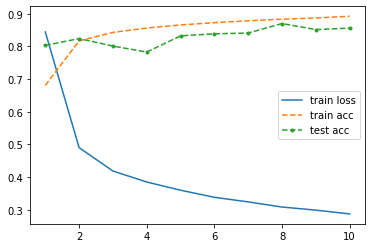

,epoch,loss,acc,val_loss,val_acc,h1_var,h2_var
1,1,0.84459,0.681023,0.524338,0.80332,0.153134,0.131115
2,2,0.490213,0.817099,0.482563,0.824121,0.155789,0.151529
3,3,0.418698,0.843052,0.527886,0.80127,0.156253,0.155169
4,4,0.385053,0.856427,0.594618,0.78291,0.158617,0.156458
5,5,0.359946,0.865924,0.458336,0.83252,0.168336,0.159086
6,6,0.338266,0.872845,0.420534,0.838867,0.17198,0.163935
7,7,0.324137,0.878685,0.425395,0.841113,0.17376,0.16482
8,8,0.308438,0.883561,0.354339,0.870215,0.178513,0.165745
9,9,0.298927,0.88724,0.401207,0.85166,0.179437,0.168425
10,10,0.287368,0.892537,0.38853,0.856152,0.185007,0.171049


In [95]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(dfhistory.index, dfhistory['loss'], label='train loss')
plt.plot(dfhistory.index, dfhistory['acc'], '--', label='train acc')
plt.plot(dfhistory.index, dfhistory['val_acc'], '.--', label='test acc')
plt.legend()
plt.show()
dfhistory

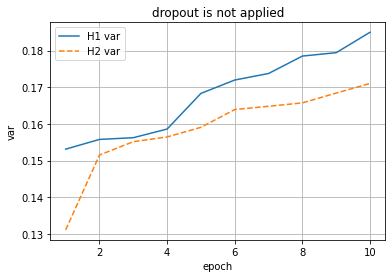

In [96]:
plt.figure()
plt.plot(dfhistory.index, dfhistory['h1_var'], label='H1 var')
plt.plot(dfhistory.index, dfhistory['h2_var'], '--', label='H2 var')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('var')
plt.title('dropout is not applied')
plt.show()
